# Road Damage Detection

## Imports

In [2]:
%pip install ultralytics
%pip install ipykernel

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import random
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import shutil
from ultralytics import YOLO
import torch
from pathlib import Path
from PIL import Image

## Data

In [3]:
# Dossier où sont mélangés images et labels
data_dir = "../data"

In [4]:
num_samples = 5  # nombre d'images à afficher

In [5]:
# === Mapping ID -> Nom de classe ===
class_names = {
    0: "longitudinal crack",
    1: "longitudinal crack wide",
    2: "transverse crack",
    3: "transverse crack wide",
    4: "alligator crack",
    5: "alligator crack sunken",
    6: "pothole",
    7: "pothole deep"
}

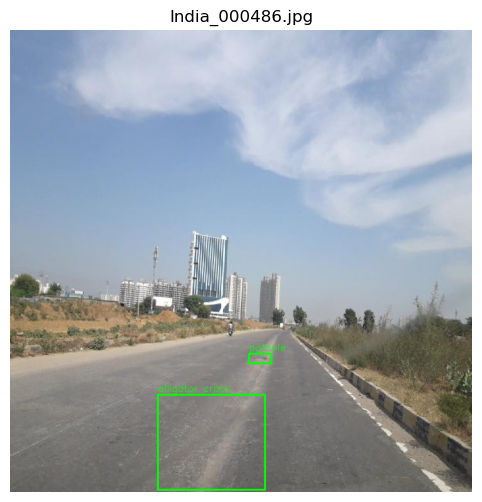

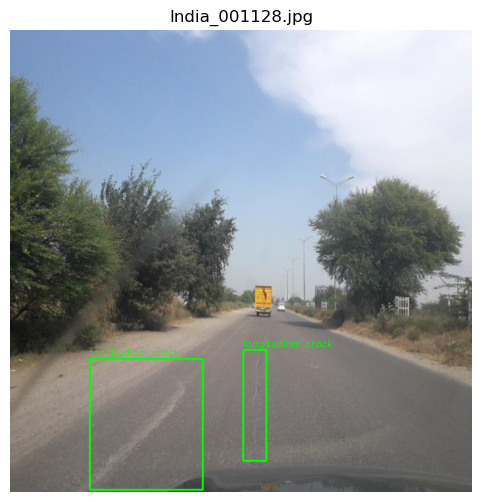

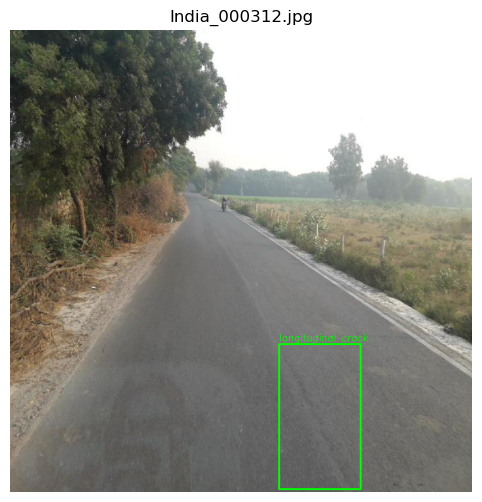

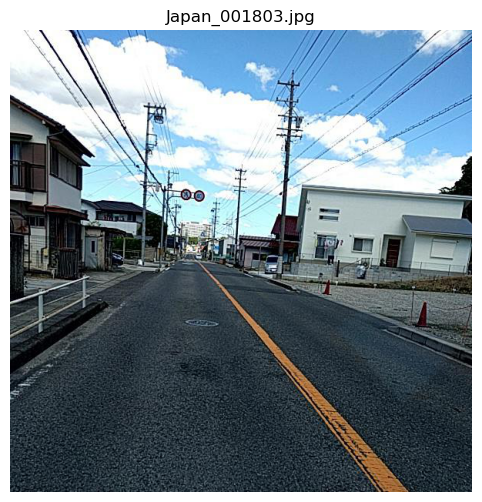

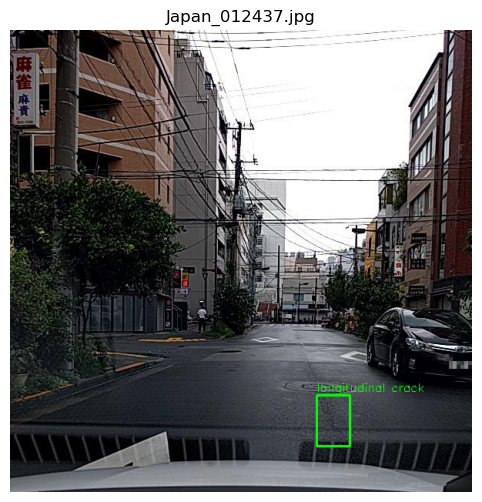

In [6]:
# Lister les fichiers images
all_images = [f for f in os.listdir(data_dir) if f.lower().endswith(('.jpg', '.png'))]
sample_images = random.sample(all_images, num_samples)

for img_file in sample_images:
    img_path = os.path.join(data_dir, img_file)
    label_path = os.path.join(data_dir, os.path.splitext(img_file)[0] + ".txt")
    
    # Charger l'image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Impossible de lire {img_file}")
        continue
    h, w = img.shape[:2]
    
    # Charger le fichier .txt associé
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                cls, x_center, y_center, bw, bh = map(float, parts)
                cls = int(cls)
                # Conversion YOLO -> pixels
                x1 = int((x_center - bw / 2) * w)
                y1 = int((y_center - bh / 2) * h)
                x2 = int((x_center + bw / 2) * w)
                y2 = int((y_center + bh / 2) * h)
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(img, class_names.get(cls, f"Unknown {cls}"), 
                            (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 
                            0.5, (0, 255, 0), 1)
    
    # Affichage
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(img_file)
    plt.axis("off")
    plt.show()

## Training

### Split

In [15]:
# === Paramètres ===
data_dir = "../data"  # dossier où sont tes images + labels
output_dir = "../dataset"  # dossier de sortie
train_ratio = 0.8  # proportion train vs val

# Créer la structure des dossiers YOLO
for split in ["train", "val"]:
    os.makedirs(os.path.join(output_dir, "images", split), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "labels", split), exist_ok=True)

# Lister toutes les images
all_images = [f for f in os.listdir(data_dir) if f.lower().endswith(('.jpg', '.png'))]
random.shuffle(all_images)

# Calcul du split
train_count = int(len(all_images) * train_ratio)
train_files = all_images[:train_count]
val_files = all_images[train_count:]

def copy_files(file_list, split):
    for img_file in file_list:
        img_path = os.path.join(data_dir, img_file)
        label_file = os.path.splitext(img_file)[0] + ".txt"
        label_path = os.path.join(data_dir, label_file)

        # Copier image
        shutil.copy(img_path, os.path.join(output_dir, "images", split, img_file))

        # Copier label si existe
        if os.path.exists(label_path):
            shutil.copy(label_path, os.path.join(output_dir, "labels", split, label_file))

# Copier train et val
copy_files(train_files, "train")
copy_files(val_files, "val")

print(f"✅ {len(train_files)} images pour train, {len(val_files)} pour val")
print(f"Données organisées dans : {output_dir}")

✅ 20480 images pour train, 5120 pour val
Données organisées dans : ../dataset


### Parameters

In [12]:
# Chemin vers ton fichier data.yaml
DATA_YAML = "../data.yaml"
# Modèle pré-entraîné
MODEL_NAME = "yolov8n.pt"
# Dossier pour sauvegarder les résultats
RESULTS_DIR = "runs/hyperparam_search"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Liste des valeurs d'epochs et taille d'image à tester
epochs_list = [10, 20, 30]
imgsz_list = [320, 640]

# DataFrame pour stocker les résultats
results_df = pd.DataFrame(columns=["epochs", "imgsz", "train_loss", "val_loss", "mAP50", "mAP50_95", "path"])

for epochs in epochs_list:
    for imgsz in imgsz_list:
        print(f"➡️ Entraînement avec epochs={epochs}, imgsz={imgsz}")

        # Créer un nom unique pour le run
        run_name = f"ep{epochs}_img{imgsz}"

        # Charger modèle
        model = YOLO(MODEL_NAME)

        # Lancer entraînement
        metrics = model.train(data=DATA_YAML, epochs=epochs, imgsz=imgsz, name=run_name, exist_ok=True)

        # Récupérer métriques principales (extrait de metrics.results)
        # .results est une liste de dictionnaires pour chaque epoch, on prend la dernière epoch
        last_epoch = metrics.results[-1]

        # Extraire métriques (keys typiques : 'train/loss', 'val/loss', 'metrics/mAP_0.5', 'metrics/mAP_0.5:0.95')
        train_loss = last_epoch.get('train/loss', None)
        val_loss = last_epoch.get('val/loss', None)
        mAP50 = last_epoch.get('metrics/mAP_0.5', None)
        mAP50_95 = last_epoch.get('metrics/mAP_0.5:0.95', None)

        # Ajouter ligne au dataframe
        results_df = pd.concat([results_df, pd.DataFrame([{
            "epochs": epochs,
            "imgsz": imgsz,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "mAP50": mAP50,
            "mAP50_95": mAP50_95,
            "path": metrics.best
        }])], ignore_index=True)

        print(f"✅ Fin entraînement {run_name} - val_loss={val_loss}, mAP50={mAP50}")

# Sauvegarder résultats
results_df.to_csv(os.path.join(RESULTS_DIR, "hyperparam_search_results.csv"), index=False)
print(f"Résultats sauvegardés dans {RESULTS_DIR}/hyperparam_search_results.csv")

➡️ Entraînement avec epochs=10, imgsz=320
Ultralytics 8.3.177  Python-3.12.11 torch-2.8.0+cpu CPU (Intel Core(TM) i5-14400F)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=ep10_img320, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plo

train: Scanning C:\Users\kevin\Documents\Solo_learning\RoadDamageDetection\dataset\labels\train.cache... 20478 images, 6635 backgrounds, 0 corrupt: 100%|██████████| 20480/20480 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.00.0 ms, read: 1458.3480.5 MB/s, size: 144.0 KB)


c:\Users\kevin\anaconda3\envs\env_RoadDamageDetection\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning C:\Users\kevin\Documents\Solo_learning\RoadDamageDetection\dataset\labels\val.cache... 5120 images, 1683 backgrounds, 0 corrupt: 100%|██████████| 5120/5120 [00:00<?, ?it/s]

Plotting labels to runs\detect\ep10_img320\labels.jpg... 



c:\Users\kevin\anaconda3\envs\env_RoadDamageDetection\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 0 dataloader workers
Logging results to runs\detect\ep10_img320
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


c:\Users\kevin\anaconda3\envs\env_RoadDamageDetection\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
       1/10         0G      2.438      3.633      1.852         13        320: 100%|██████████| 1280/1280 [17:50<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 160/160 [01:45<00:00,  1.52it/s]


                   all       5120       7161      0.166      0.195     0.0825     0.0302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      2.252      2.811      1.714         17        320: 100%|██████████| 1280/1280 [16:29<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 160/160 [01:43<00:00,  1.55it/s]


                   all       5120       7161      0.168      0.187      0.107     0.0394

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      2.193      2.647      1.677         16        320: 100%|██████████| 1280/1280 [15:56<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 160/160 [01:42<00:00,  1.56it/s]


                   all       5120       7161        0.3      0.212      0.143      0.056

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      2.136      2.546      1.634         18        320:  61%|██████▏   | 786/1280 [10:00<06:17,  1.31it/s]


KeyboardInterrupt: 

### Train

In [16]:
print(torch.__version__)
print(torch.version.cuda)  # Version CUDA utilisée par PyTorch
print(torch.cuda.is_available())  # True si le GPU est dispo

2.8.0+cpu
None
False


In [17]:
if torch.cuda.is_available():
    print(f"✅ GPU détecté : {torch.cuda.get_device_name(0)}")
    device = 0  # GPU index
else:
    print("⚠ Aucun GPU détecté, entraînement sur CPU")
    device = 'cpu'

⚠ Aucun GPU détecté, entraînement sur CPU


In [18]:
model = YOLO('yolov8n.pt')

# 2. On lance l'entraînement avec ces paramètres :
# - data='../data.yaml' : fichier qui contient le chemin vers les données, le nombre de classes, et leurs noms
# - epochs=10 : nombre d'itérations sur tout le dataset (plus c'est grand, mieux c'est, mais ça prend plus de temps)
# - imgsz=640 : taille des images utilisées pendant l'entraînement (les images seront redimensionnées à 640x640)
results = model.train(data='../data.yaml', epochs=10, imgsz=640)

# 3. Une fois l'entraînement terminé, on affiche un message
print("Entraînement terminé.")

Ultralytics 8.3.177  Python-3.12.11 torch-2.8.0+cpu CPU (Intel Core(TM) i5-14400F)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=../data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=F

train: Scanning C:\Users\kevin\Documents\Solo_learning\RoadDamageDetection\dataset\labels\train... 20479 images, 6651 backgrounds, 0 corrupt: 100%|██████████| 20480/20480 [00:27<00:00, 753.28it/s]


train: New cache created: C:\Users\kevin\Documents\Solo_learning\RoadDamageDetection\dataset\labels\train.cache
val: Fast image access  (ping: 0.00.0 ms, read: 20.37.2 MB/s, size: 107.3 KB)


c:\Users\kevin\anaconda3\envs\env_RoadDamageDetection\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning C:\Users\kevin\Documents\Solo_learning\RoadDamageDetection\dataset\labels\val... 5119 images, 1667 backgrounds, 0 corrupt: 100%|██████████| 5120/5120 [00:06<00:00, 765.64it/s]

val: New cache created: C:\Users\kevin\Documents\Solo_learning\RoadDamageDetection\dataset\labels\val.cache



c:\Users\kevin\anaconda3\envs\env_RoadDamageDetection\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train2
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


c:\Users\kevin\anaconda3\envs\env_RoadDamageDetection\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
       1/10         0G      2.105      4.103      1.914         17        640: 100%|██████████| 1280/1280 [1:03:12<00:00,  2.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 160/160 [09:02<00:00,  3.39s/it]


                   all       5120       7311      0.185       0.26      0.132     0.0526

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.965      2.752      1.798         36        640: 100%|██████████| 1280/1280 [51:00<00:00,  2.39s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 160/160 [03:47<00:00,  1.42s/it]


                   all       5120       7311      0.463      0.217      0.178     0.0761

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.926      2.545      1.773         33        640: 100%|██████████| 1280/1280 [39:35<00:00,  1.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 160/160 [03:47<00:00,  1.42s/it]


                   all       5120       7311      0.213      0.273      0.179     0.0788

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.878      2.408      1.738         16        640: 100%|██████████| 1280/1280 [39:27<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 160/160 [03:46<00:00,  1.41s/it]


                   all       5120       7311      0.306      0.315      0.233      0.108

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.824      2.282      1.695         20        640: 100%|██████████| 1280/1280 [39:26<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 160/160 [03:46<00:00,  1.41s/it]


                   all       5120       7311      0.342       0.34      0.262      0.121

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.762      2.163      1.638         19        640: 100%|██████████| 1280/1280 [42:11<00:00,  1.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 160/160 [04:30<00:00,  1.69s/it]


                   all       5120       7311      0.364      0.393      0.321      0.154

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.727       2.08      1.616         14        640: 100%|██████████| 1280/1280 [47:11<00:00,  2.21s/it] 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 160/160 [03:54<00:00,  1.46s/it]


                   all       5120       7311      0.392      0.394      0.345      0.171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.688      2.004      1.589         21        640: 100%|██████████| 1280/1280 [1:08:01<00:00,  3.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 160/160 [05:46<00:00,  2.17s/it]


                   all       5120       7311       0.37      0.415       0.37      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      1.654      1.925      1.561         19        640: 100%|██████████| 1280/1280 [1:41:54<00:00,  4.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 160/160 [09:06<00:00,  3.41s/it]


                   all       5120       7311      0.412      0.436      0.387        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.606      1.853      1.529         16        640: 100%|██████████| 1280/1280 [1:40:20<00:00,  4.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 160/160 [09:06<00:00,  3.41s/it]


                   all       5120       7311      0.425      0.448      0.395      0.207

10 epochs completed in 10.818 hours.
Optimizer stripped from runs\detect\train2\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train2\weights\best.pt, 6.2MB

Validating runs\detect\train2\weights\best.pt...
Ultralytics 8.3.177  Python-3.12.11 torch-2.8.0+cpu CPU (Intel Core(TM) i5-14400F)
Model summary (fused): 72 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 160/160 [07:55<00:00,  2.97s/it]


                   all       5120       7311      0.427      0.446      0.395      0.207
    longitudinal crack       1820       2673      0.553       0.58       0.57      0.311
longitudinal crack wide        424        473       0.36       0.48      0.375      0.228
      transverse crack       1043       1503      0.505       0.49      0.478      0.231
 transverse crack wide        136        142      0.343      0.265      0.211        0.1
       alligator crack       1080       1304       0.51      0.605      0.541      0.284
alligator crack sunken        164        184      0.371      0.424      0.324      0.179
               pothole        563        937      0.484       0.38      0.365      0.163
          pothole deep         84         95      0.287      0.347      0.296      0.157
Speed: 0.9ms preprocess, 81.6ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs\detect\train2
Entraînement terminé.


In [19]:
model.save("../models/model.pt")
print("✅ Modèle sauvegardé sous ../models/model.pt")

✅ Modèle sauvegardé sous ../models/model.pt


In [4]:
# Charger le modèle entraîné
model = YOLO('runs/detect/train2/weights/best.pt') 

# Prédire sur toutes les images d’un dossier
results = model.predict(
    source='../dataset/images/val/',  # Dossier contenant tes images
    imgsz=640,        # Taille d'entrée du modèle
    conf=0.25,        # Seuil de confiance
    save=True         # Sauvegarde les images annotées
)

# Trouver le dossier où YOLO a sauvegardé les résultats
save_dir = Path(results[0].save_dir)

print(f"Résultats sauvegardés dans : {save_dir}")



WARNING 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/5120 c:\Users\kevin\Documents\Solo_learning\RoadDamageDetection\scripts\..\dataset\images\val\Czech_000002.jpg: 640x640 (no detections), 112.2ms
image 2/5120 c:\Users\kevin\Documents\Solo_learning\RoadDamageDetection\scripts\..\dataset\images\val\Czech_000005.jpg: 640x640 1 longitudinal crack, 59.2ms
image 3/5120 c:\Users\kevin\Documents\Solo_learning\RoadDamageDetection\scripts\..\dataset\images\val\Czech_000006.jpg: 640x640 1 longitudinal crack,